# Predicting Stock Returns with supervised learning-based models

In this project we will use historical data and correlated assets to predict the stock price of Microsoft ('MSFT').

The exercise stems from this [book](https://www.oreilly.com/library/view/machine-learning-and/9781492073048/). Adaptions were necessary to account for library/package version and development environments.

# 1. Problem Definition

Weekly return of 'MSFT' will be treated as the dependent variable in the supervised regression framework. Additionally, we want to include as much relevant information as possible inside the regressions. Therefore, the following correlated assets will be used as independent variables:

* Stocks: IBM (IBM) and Alphabet (GOOGL)
* Currency: USD/JPY and GPB/USD
* Indices: S&P 500, Dow Jones, and VIX

# 2. Loading Data, Libraries, and Packages

In [1]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

In [2]:
# Libraries

import numpy as np
import pandas as pd
import datetime
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor 
from sklearn.neural_network import MLPRegressor

# Deep learning libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

# Statistical models libraries
import statsmodels.api as sm

# Libraries for saving the model
from pickle import dump
from pickle import load

# Time series models
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error metrics
from sklearn.metrics import mean_squared_error

# Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

# Plotting
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

Given that our predicted variable is the weekly return of MSFT, we set the 5 business day lagged period as our typical week. Additionally, we must reframe the time series into a supervised regression-based model framework. 

In [4]:
return_period = 5

In [5]:
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

# Correlated Stocks
X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()

# Correlated Currencies
X2 = np.log(ccy_data).diff(return_period)

# Correlated Indices
X3 = np.log(idx_data).diff(return_period)

# Lagged 5, 15, 30, and 60-day returns of MSFT
X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1, X2, X3, X4], axis=1)

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

# 3. Exploratory Data Analysis

In [6]:
# Descriptive Statistics 1

pd.set_option('precision', 3)
dataset.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,225.000,225.000,2.250e+02,2.250e+02,2.250e+02,225.000,225.000,225.000,225.000,225.000,225.000,225.000
mean,0.006,0.004,3.474e-04,3.438e-04,-3.063e-04,0.002,0.002,0.006,0.006,0.020,0.041,0.080
std,0.033,0.036,3.683e-02,1.018e-02,1.255e-02,0.025,0.028,0.167,0.031,0.046,0.059,0.066
min,-0.153,-0.159,-1.683e-01,-3.293e-02,-5.492e-02,-0.162,-0.190,-0.559,-0.145,-0.165,-0.288,-0.134
25%,-0.010,-0.011,-1.637e-02,-5.645e-03,-7.123e-03,-0.005,-0.007,-0.076,-0.008,-0.003,0.012,0.045
50%,0.007,0.008,1.558e-03,1.013e-03,-1.438e-03,0.004,0.004,-0.003,0.007,0.018,0.042,0.082
75%,0.025,0.023,1.734e-02,6.273e-03,7.007e-03,0.014,0.014,0.074,0.024,0.050,0.076,0.121
max,0.100,0.134,1.304e-01,4.038e-02,5.121e-02,0.098,0.121,0.910,0.100,0.186,0.285,0.283


In [7]:
# Descriptive Statistics 2

dataset.head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2016-11-01,0.011,-0.028,0.013,0.003,0.004,-0.015,-0.007,0.321,-0.020,0.045,0.051,0.036
2016-11-08,-0.020,0.008,0.024,0.004,0.013,0.013,0.016,0.010,0.011,0.048,0.043,0.046
2016-11-16,0.012,-0.032,0.029,0.040,-0.002,0.006,0.015,-0.047,-0.002,-0.010,0.041,0.037
2016-11-25,-0.021,-0.008,0.021,0.024,0.011,0.014,0.015,-0.040,-0.002,0.029,0.068,0.059
2016-12-05,0.032,-0.010,-0.029,0.015,0.024,0.001,0.006,-0.080,-0.006,0.027,0.016,0.076


## Histograms, KDEs, Correlation matrices, Scatterplots, and Time-Series can be used to better understand interdependency in the data.

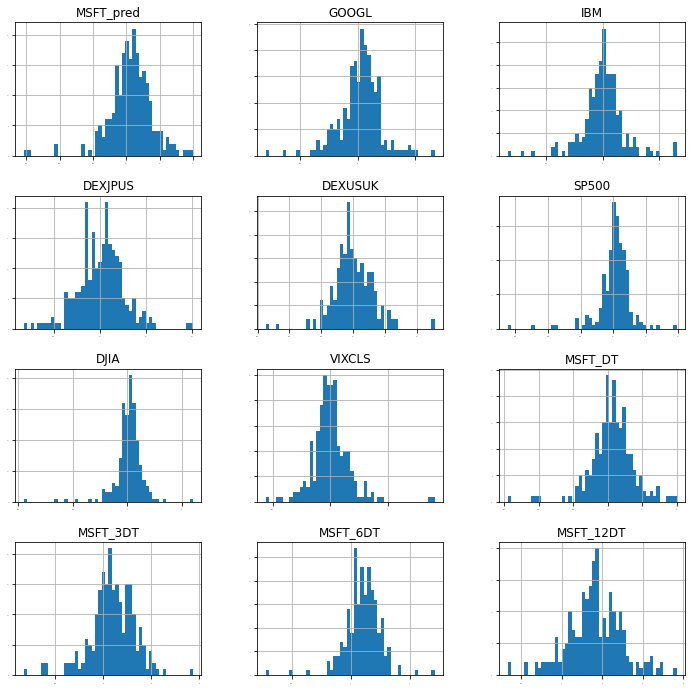

In [8]:
# Histogram

dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

Based on the visualizations above, we can infer that some assets such as S&P500 are left-skewed. Most MSFT periods also seem to have slightly similar characteristics. 

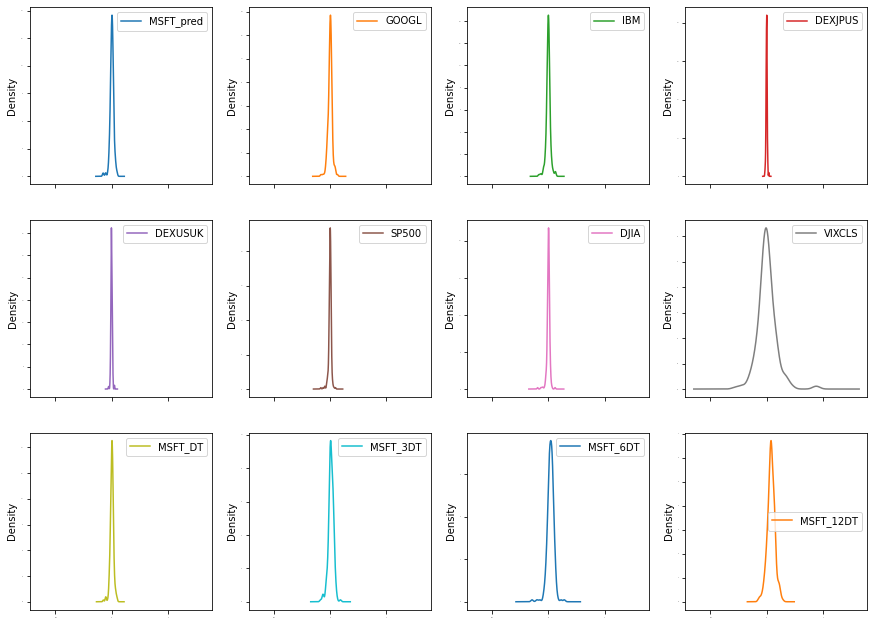

In [9]:
# KDE

dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

One possible insight derived from the plots above is that VIX has a much higher variance compared to other assets.

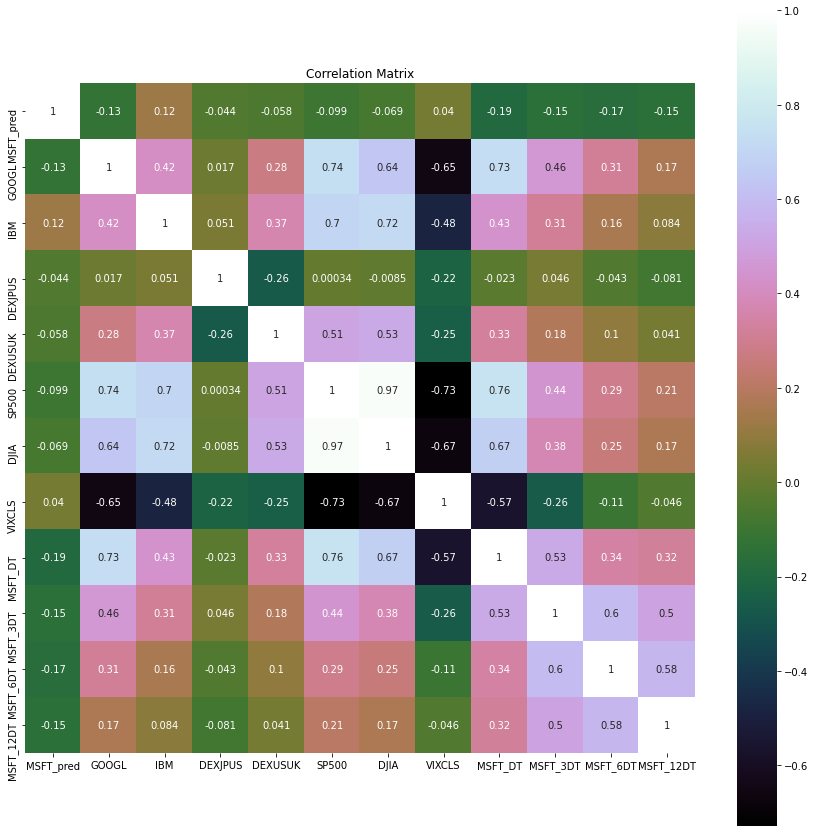

In [10]:
# Correlation Matrix

correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')

The correlation plot above does seem to indicate some correlation between our dependent variable and the several lagged MSFT returns. There also seems to be a negative correlation of some assets versus VIX.

<Figure size 1080x1080 with 0 Axes>

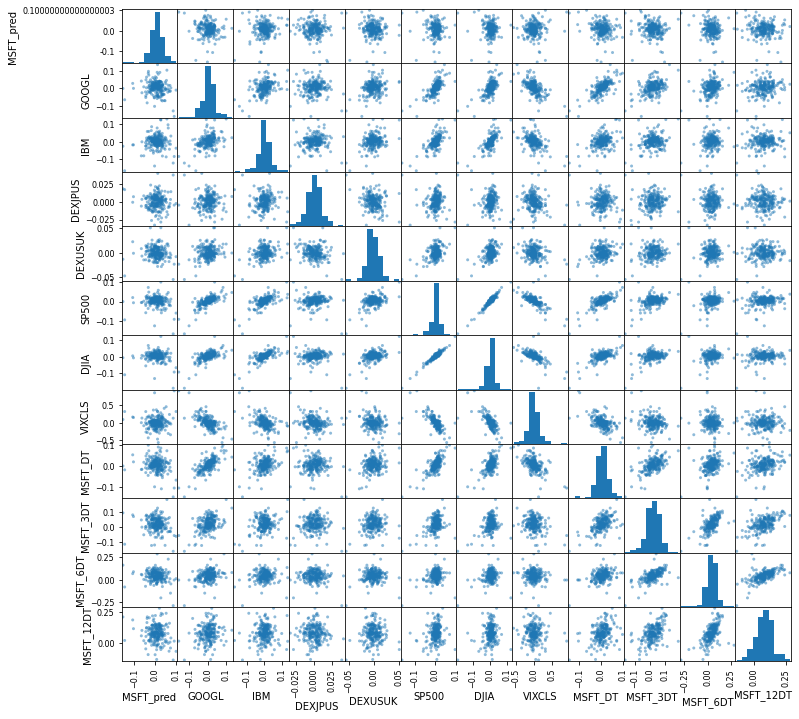

In [11]:
# Scatter Plot

pyplot.figure(figsize=(15,15))
scatter_matrix(dataset, figsize=(12,12))
pyplot.show()

Once again, the plot above seem to indicate a slight linear relationship between our dependent variable and the several lagged MSFT returns.

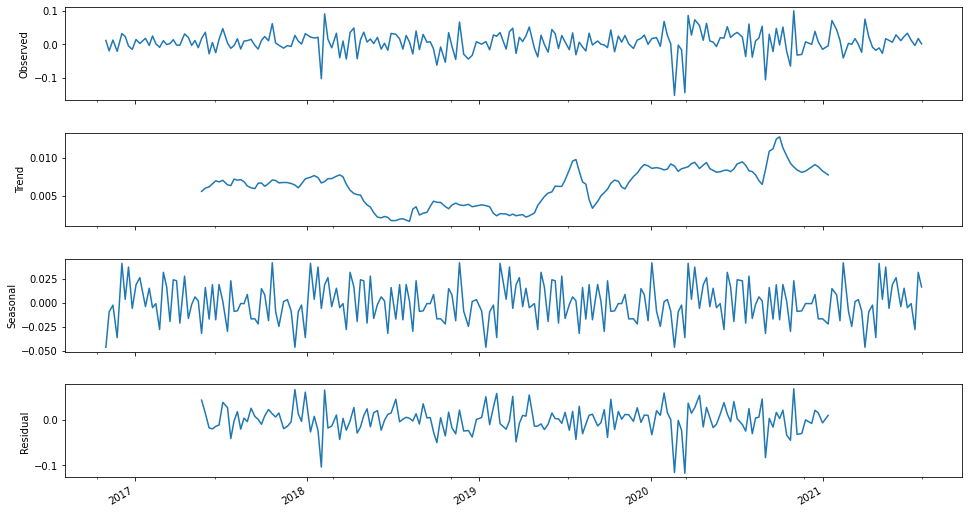

In [12]:
# Time Series Analysis

res = sm.tsa.seasonal_decompose(Y, freq=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

We can now see a general upwards trend for MSFT returns. This element should reappear in our constant and bias terms in the models.

# 4. Data Preparation

In [13]:
# Feature Selection
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X, Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# Concatenating dataframes for better visualization
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']
featureScores.nlargest(10, 'Score').set_index('Specs')

,Score
Specs,
MSFT_DT,8.628
MSFT_6DT,6.316
MSFT_12DT,5.217
MSFT_3DT,4.972
GOOGL,3.597
IBM,3.397
SP500,2.191
DJIA,1.062
DEXUSUK,0.753


This step indicates MSFT_DT as the most important feature and DEXJPUS as the least important.

# 5. Evaluating Algorithms and Modes

In [14]:
# Train-Test Split
validation_size = 0.2
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

In [15]:
# Testing options and evaluation metrics
num_folds=10
seed=7
scoring='neg_mean_squared_error'

Comparing Algorithms and Models

In [16]:
# Regression and Tree Regression Algorithms
models=[]
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [17]:
# Neural Network Algorithms
models.append(('MLP', MLPRegressor()))

In [18]:
# Ensemble Models
## Boosting Methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
## Bagging Methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [19]:
names = []
kfold_results = []
train_results = []
test_results = []


for name, model in models:
  names.append(name)

  # K-Fold Analysis
  kfold = KFold(n_splits=num_folds, random_state=seed)
  cv_results = -1 * cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
  kfold_results.append(cv_results)

  # Full Training Period
  res = model.fit(X_train, Y_train)
  train_result = mean_squared_error(res.predict(X_train), Y_train)
  train_results.append(train_result)

  # Test Results
  test_result = mean_squared_error(res.predict(X_test), Y_test)
  test_results.append(test_result)

  msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
  print(msg)

LR: 0.001101 (0.000836) 0.000879 0.001294
LASSO: 0.001037 (0.000946) 0.001023 0.001284
EN: 0.001037 (0.000946) 0.001023 0.001284
KNN: 0.001183 (0.001063) 0.000792 0.001283
CART: 0.001950 (0.001693) 0.000000 0.002098
SVR: 0.002627 (0.000832) 0.002628 0.002989
MLP: 0.001848 (0.000917) 0.003510 0.003186
ABR: 0.001152 (0.000984) 0.000459 0.001323
GBR: 0.001336 (0.001137) 0.000078 0.001204
RFR: 0.001278 (0.001137) 0.000184 0.001330
ETR: 0.001178 (0.000995) 0.000000 0.001372


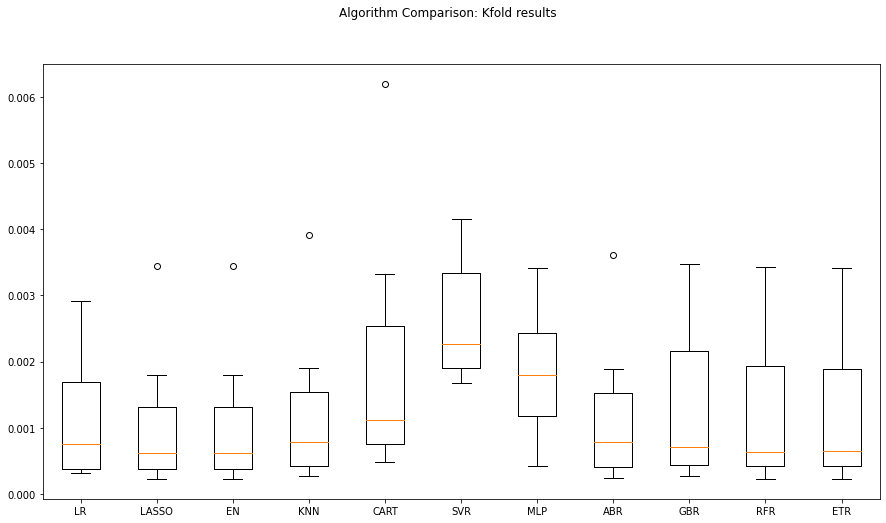

In [20]:
# K-fold results
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

This plot indicates that all models except CART, SVR, and MLP seem to do a relatively good job. However, LR, GBR, RFR, and ETR still present longer top whiskers, indicating higher variability outside their upper quartiles.

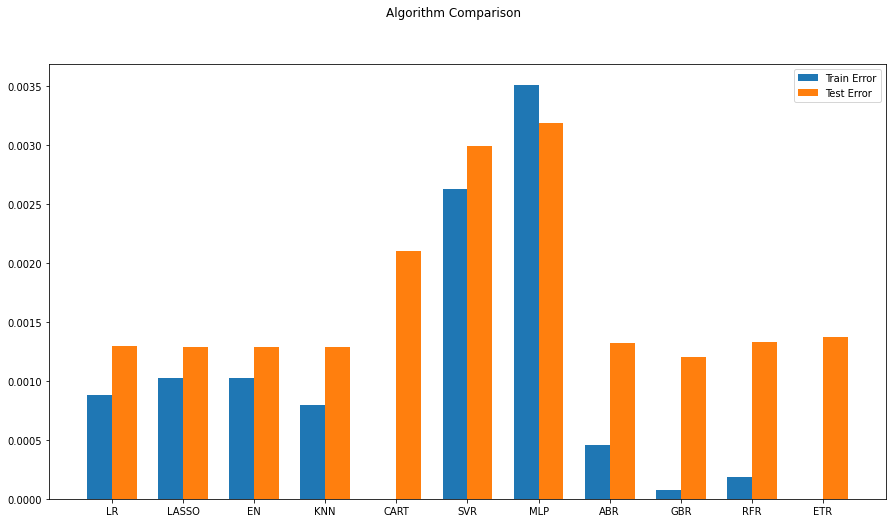

In [21]:
# Training and Test Error
fig = pyplot.figure()
ind = np.arange(len(names))
width = 0.35

fig.suptitle('Algorithm Comparison')
ax=fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results, width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)

pyplot.show()

Looking at the training and test error, we can once see a better overall performance of the linear models. 

The CART algorithm, on the other hand, overfitts the training data and produces high error with the test set. 

Ensemble models such as ABR, GBR, and RFR, seem to have low bias but high variance.

Finally, MLP and SVR show higher errors on both training and test errors. This can be attributed to linear relationships not being captured accurately, improper hyperparameters, or insufficient training of the models.

In [22]:
# Time Series - ARIMA Model

X_train_ARIMA = X_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA = X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len(X)

modelARIMA = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=[1,0,0])
model_fit = modelARIMA.fit()

error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len - 1, end = to_len - 1, exog=X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test, predicted)
error_Test_ARIMA

0.0012993413218592234

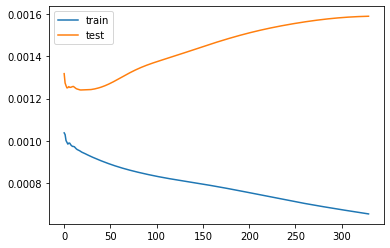

In [23]:
# Time Series - LSTM Model

seq_len = 2

Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
  X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
  X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]

# Network
def create_LSTMmodel(neurons=12, learn_rate=0.01, momentum=0):
  model = Sequential()
  model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
  model.add(Dense(1))
  optimizer = SGD(lr=learn_rate, momentum=momentum)
  model.compile(loss='mse', optimizer='adam')
  return model

LSTMModel = create_LSTMmodel(12, learn_rate=0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM), epochs=330, batch_size=72, verbose=0, shuffle=False)

# Plot to check if the error is reducing
pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [24]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test, predicted)

In [25]:
test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)

train_results.append(error_Training_ARIMA)
train_results.append(error_Training_LSTM)

names.append('ARIMA')
names.append('LSTM')

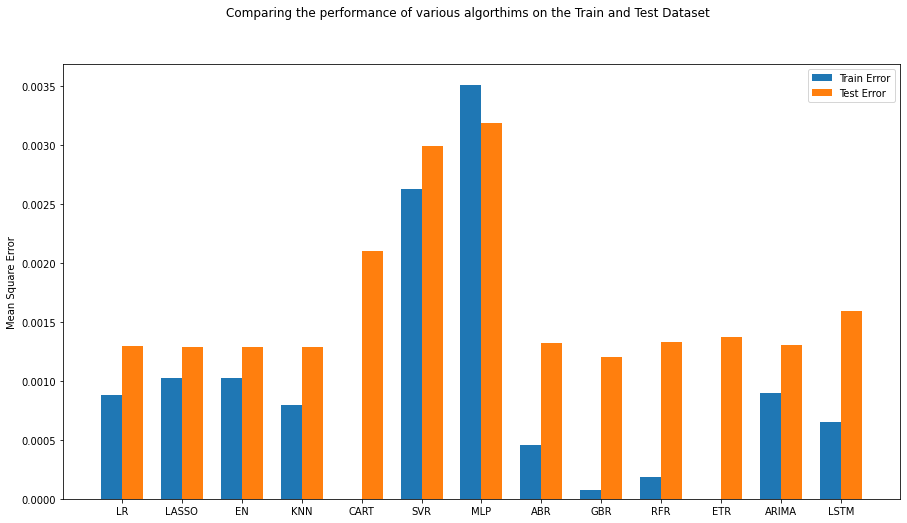

In [26]:
# Overall comparison of all algorithms (Including Time Series Algorithms)
fig = pyplot.figure()

ind = np.arange(len(names))
width = 0.35

fig.suptitle('Comparing the performance of various algorthims on the Train and Test Dataset')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.ylabel('Mean Square Error')
pyplot.show()

The plot above indicates that the ARIMA model is comparable in performance to linear models. This can be explained by the alledged strong linear relationship in the data. Although the LSTM also performs well, its Test Error is still superior to ARIMA. Therefore, we will select ARIMA for model tuning.

# 6. Model Tuning and Grid Search

In [27]:
# Grid Search for ARIMA Model

def evaluate_arima_model(arima_order):
  modelARIMA=ARIMA(endog=Y_train, exog=X_train_ARIMA, order=arima_order)
  model_fit = modelARIMA.fit()
  error = mean_squared_error(Y_train, model_fit.fittedvalues)
  return error

def evaluate_models(p_values, d_values, q_values):
  best_score, best_cfg = float('inf'), None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p,d,q)

        try:
          mse = evaluate_arima_model(order)
          if mse < best_score:
            best_score, best_cfg = mse, order

          print('ARIMA%s MSE=%.7f' %(order,mse))
        
        except:
          continue
  print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))

p_values = [0, 1, 2]
d_values = range(0,2)
q_values = range(0,2)
warnings.filterwarnings('ignore')
evaluate_models(p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.0009139
ARIMA(0, 0, 1) MSE=0.0008989
ARIMA(1, 0, 0) MSE=0.0008934
ARIMA(1, 0, 1) MSE=0.0009094
ARIMA(2, 0, 0) MSE=0.0008918
ARIMA(2, 0, 1) MSE=0.0008893
Best ARIMA(2, 0, 1) MSE=0.0008893


# 7. Finalise the Model

In [28]:
# Prepare model
modelARIMA_tuned = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=[2,0,1])
model_fit_tuned = modelARIMA_tuned.fit()

# Estimate accuracy on validation set
predicted_tuned = model_fit.predict(start=tr_len - 1, end=to_len -1, exog=X_test_ARIMA)[1:]
print(mean_squared_error(Y_test, predicted_tuned))

0.0012993413218592234


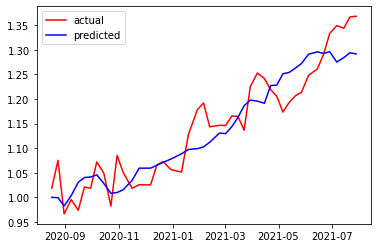

In [29]:
# Comparing actual vs predicted

predicted_tuned.index = Y_test.index
pyplot.plot(np.exp(Y_test).cumprod(), 'r', label='actual')
pyplot.plot(np.exp(predicted_tuned).cumprod(), 'b', label='predicted')
pyplot.rcParams['figure.figsize'] = (8,5)
pyplot.legend()
pyplot.show()

Although the predicted series is less volatile than actual, it still successfully captures the overall trend of MSFT returns.

In [30]:
# Save model for later use
from pickle import dump
from pickle import load

# Save model to disk
filename = 'finalized_model.sav'
dump(model_fit_tuned, open(filename, 'wb'))

# Sumary

This project allows us to conclude that simpler models such as linear regressions and ARIMA time series models are good approaches for stock price prediction problems. They are robust against overfitting and underfitting.

There is a possibility to improve model performance by managing additional hyperparameters and including new independent variables such as P/E ratio, trading volume, technical indicators, and news data.